# Comparison: Jan 31, 2023 to Jan 1, 2024 (hindcast to production)

In [1]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
year = '2023'
olddir = '/results2/SalishSea/nowcast-green.202111/'
newdir = olddir

In [8]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, it=0, twoD=False, olddir=olddir, d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
            f'{olddir}/31dec23/SalishSea_1h_20231231_20231231_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][it], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][it, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title("31Dec23")
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'{newdir}/01jan24/SalishSea_1h_20240101_20240101_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][it], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][it, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title("01Jan04")
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [12]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False, it=0):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'{olddir}/31dec23/SalishSea_1h_20231231_20231231_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[it]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][it], mask=1-tmask[0])
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'{newdir}/01jan24/SalishSea_1h_20240101_20240101_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[it]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][it], mask=1-tmask[0])
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    ds.close()
    dm.close()

    
    axs[0].invert_yaxis()
    axs[0].legend(loc='best')
    
    axs[1].invert_yaxis()
    axs[1].legend(loc='best')
    
    return fig

In [25]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, it=0, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'{olddir}/31dec23/SalishSea_1h_20231231_20231231_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[it]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][it])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'{newdir}/01jan24/SalishSea_1h_20240101_20240101_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[it]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][it])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

## Temperature

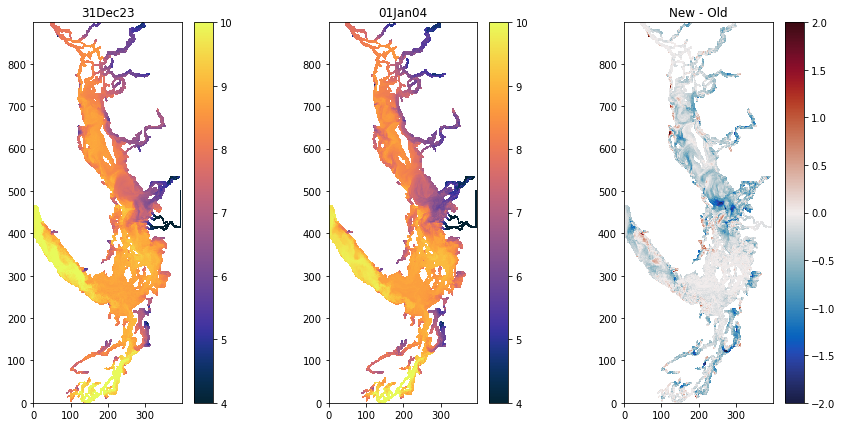

In [26]:
tracer = 'votemper'
file = 'grid'
month = '01'
cmap = cm.thermal
cdiff = cm.balance
vmax = 10
vmin = 4
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

9.490798164537168 9.492534443489292


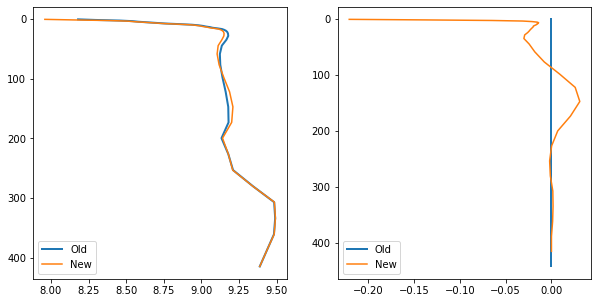

In [27]:
fig = profiles(tracer, file, it=23)

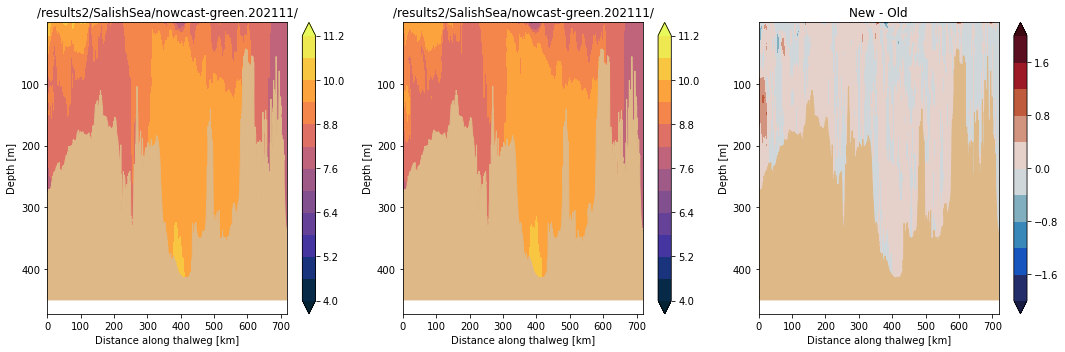

In [29]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Nitrate

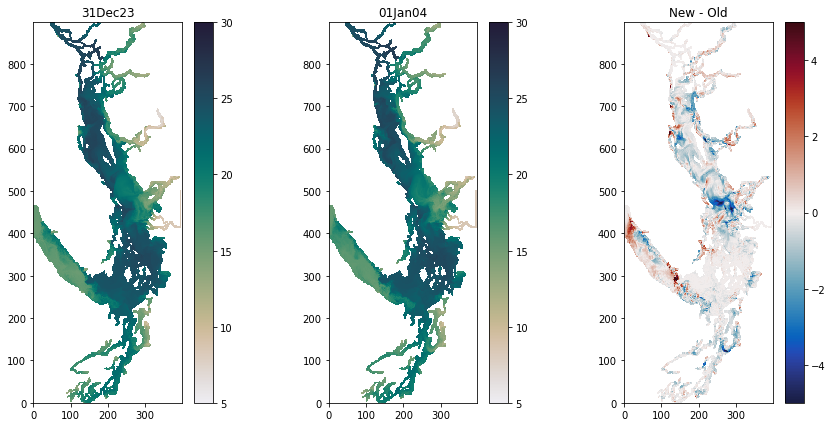

In [30]:
tracer = 'nitrate'
file = 'biol'
month = '01'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 5
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

28.75483840401033 28.762173293329734


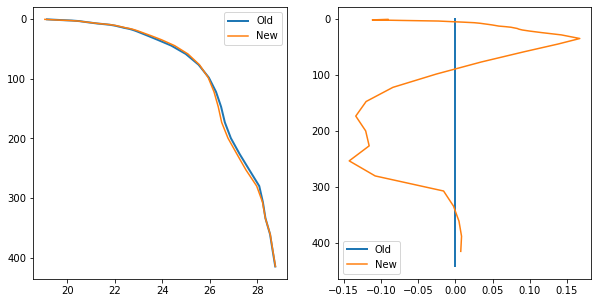

In [31]:
fig = profiles(tracer, file, it=23)

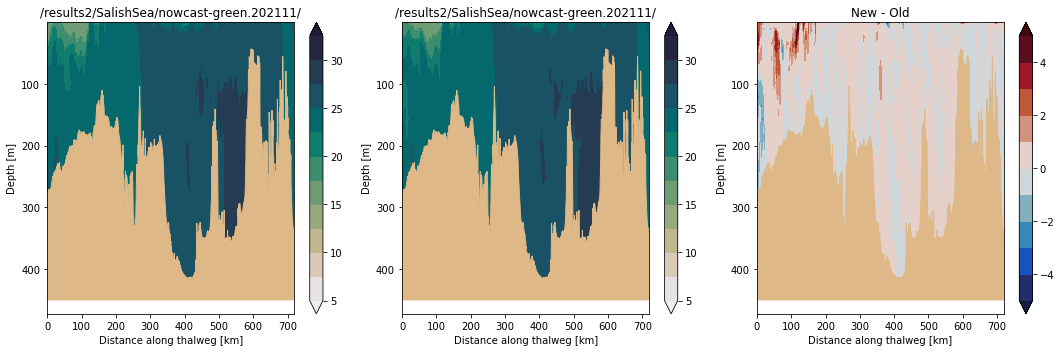

In [34]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Diatoms

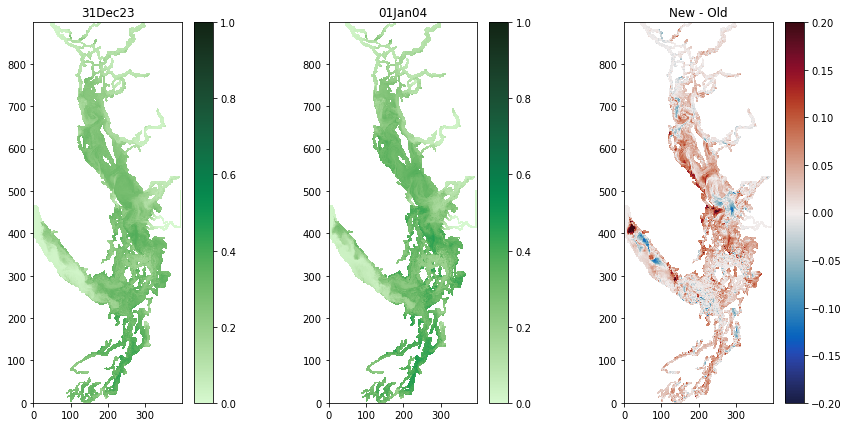

In [35]:
tracer = 'diatoms'
file = 'biol'
month = '03'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

0.19443088064761915 0.22015251360295876


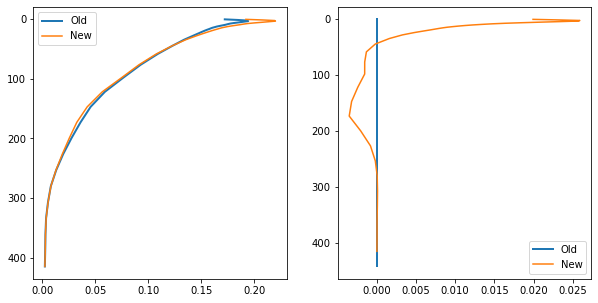

In [36]:
fig = profiles(tracer, file, it=23)

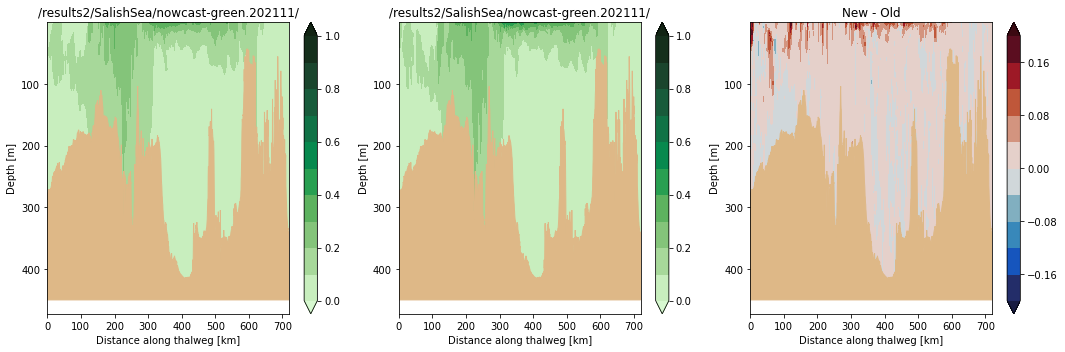

In [37]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Microzooplankton

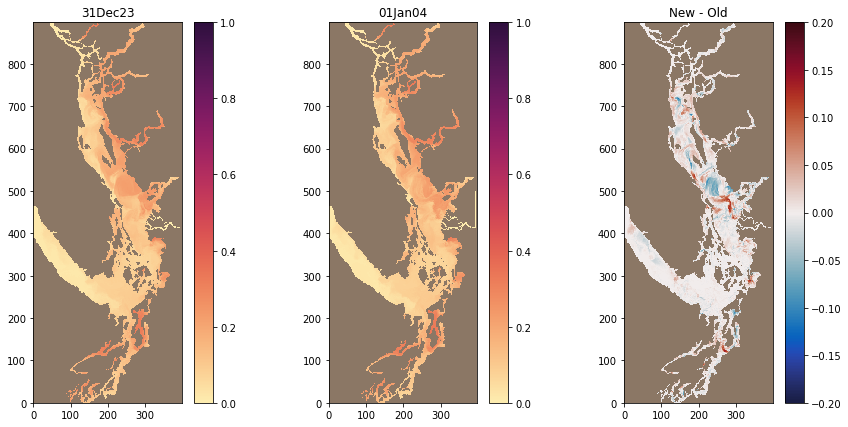

In [39]:
tracer = 'microzooplankton'
file = 'biol'
month = '04'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 1
vmin = 0
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

0.11214142978407379 0.11361438534592577


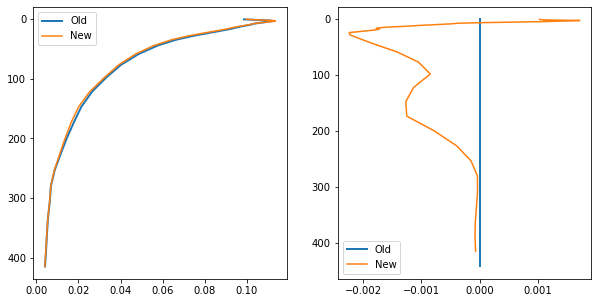

In [40]:
fig = profiles(tracer, file, it=23)

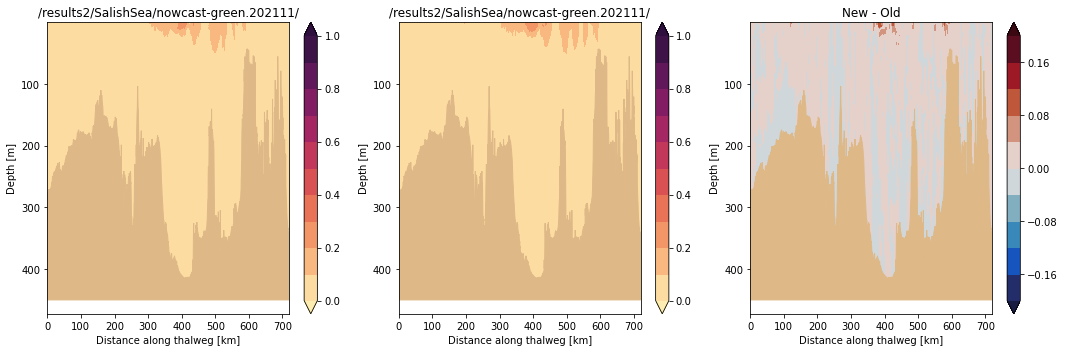

In [41]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Salinity

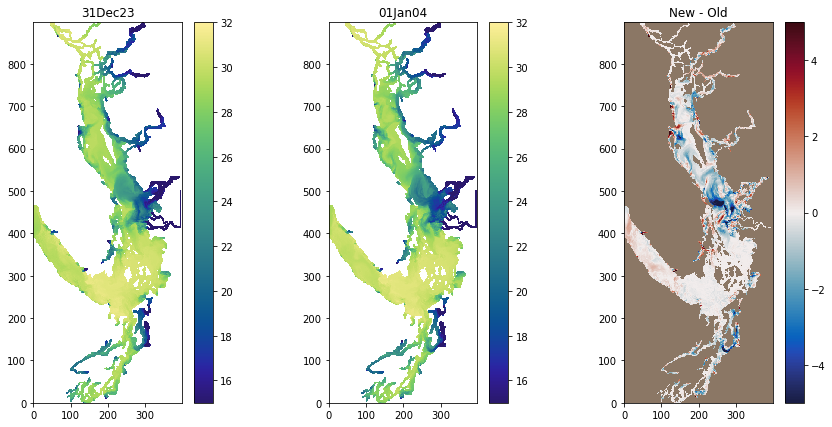

In [42]:
tracer = 'vosaline'
file = 'grid'
month = '01'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

31.42755254018043 31.451650764588823


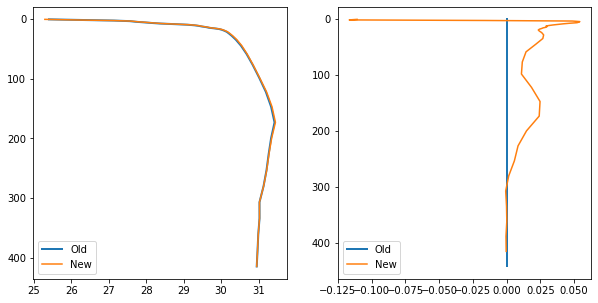

In [43]:
fig = profiles(tracer, file, it=23)

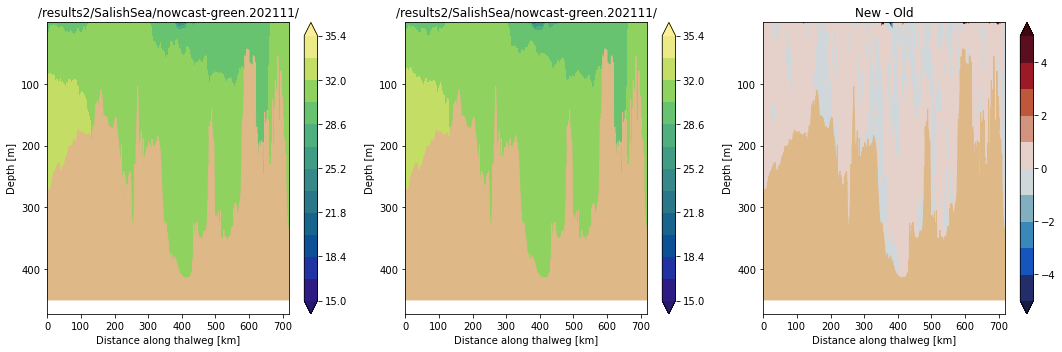

In [44]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Flagellates

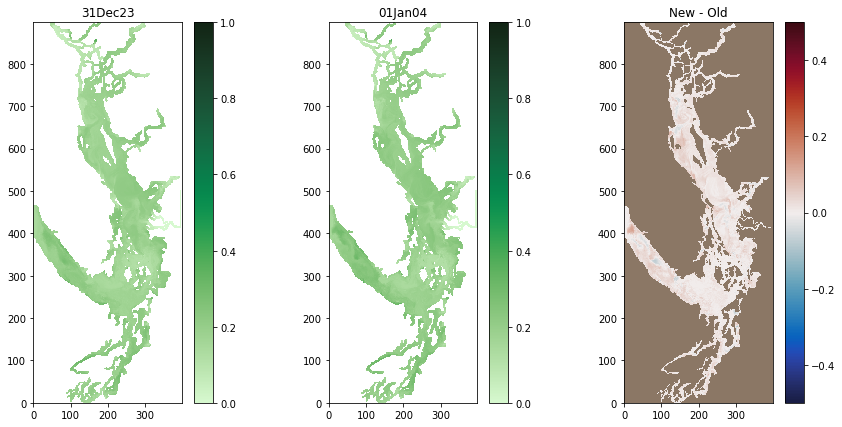

In [45]:
tracer = 'flagellates'
file = 'biol'
month = '06'
cmap = cm.algae
cdiff = cm.balance
vmax = 1
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

0.1770135005730543 0.1916808677963679


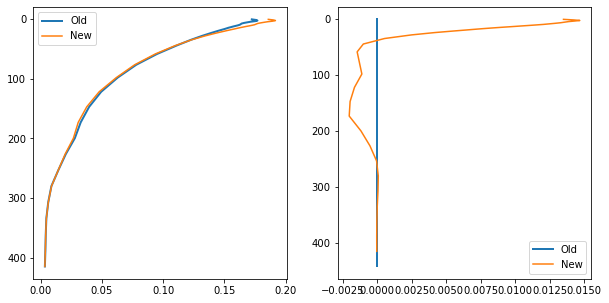

In [46]:
fig = profiles(tracer, file, it=23)

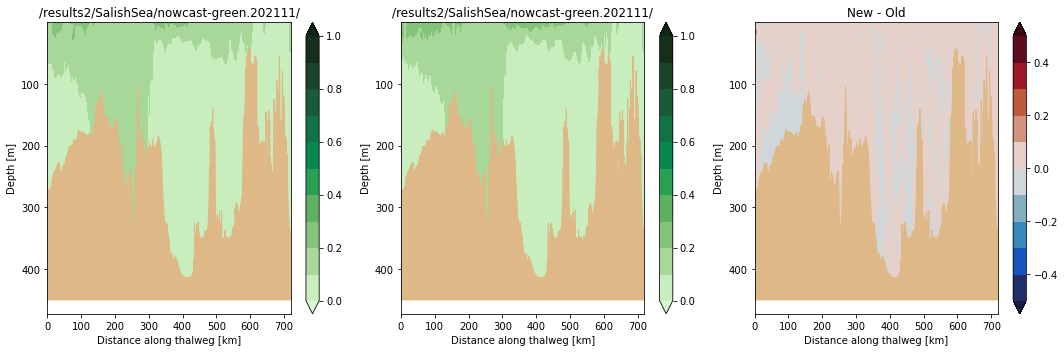

In [47]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## NH4

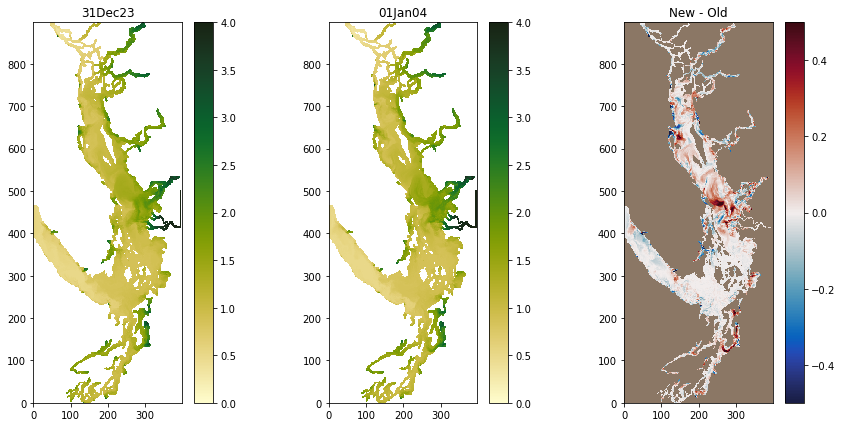

In [50]:
tracer = 'ammonium'
file = 'biol'
month = '07'
cmap = cm.speed
cdiff = cm.balance
vmax = 4
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

1.254790266921003 1.2620935213710267


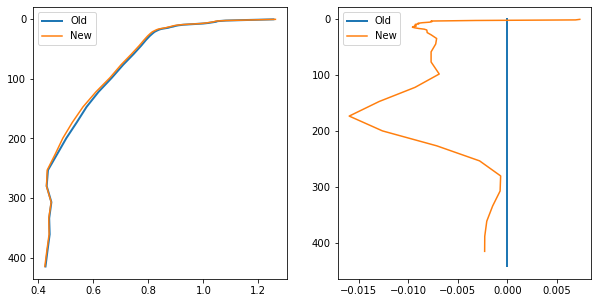

In [51]:
fig = profiles(tracer, file, it=23)

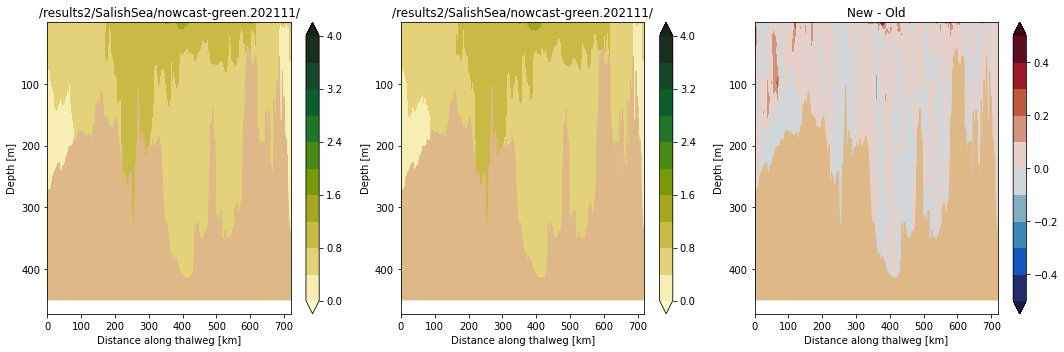

In [53]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## SSH

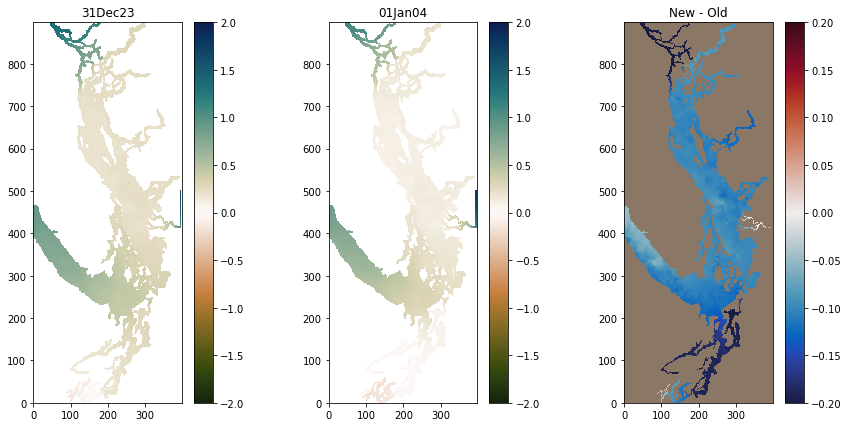

In [56]:
tracer = 'sossheig'
file = 'grid'
month = '08'
cmap = cm.tarn
cdiff = cm.balance
vmax = 2
vmin = -2
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23, twoD=True)

## PON

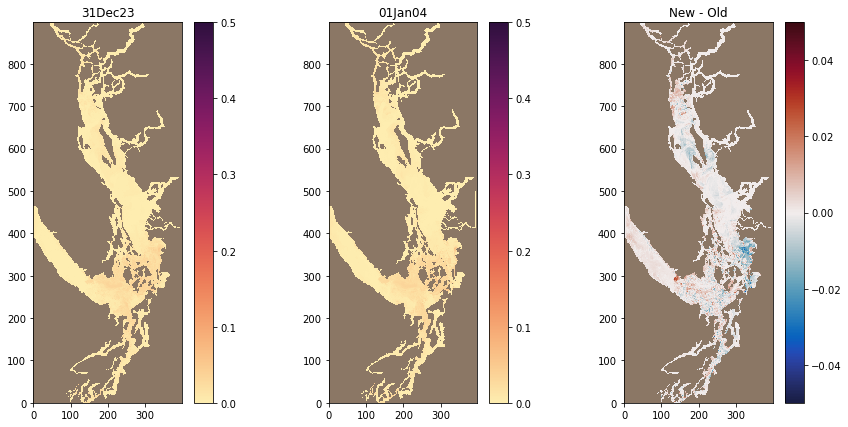

In [57]:
tracer = 'particulate_organic_nitrogen'
file = 'biol'
month = '09'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.5
vmin = 0
dvmax = 0.05
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

0.032410340104186114 0.03176999664719482


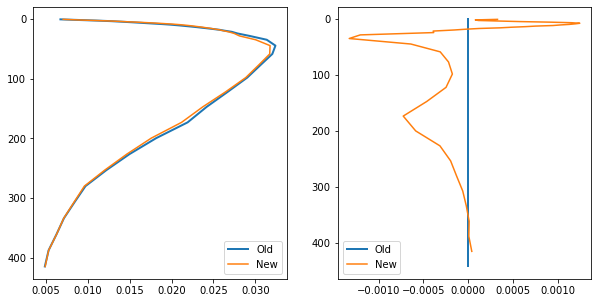

In [58]:
fig = profiles(tracer, file, it=23)

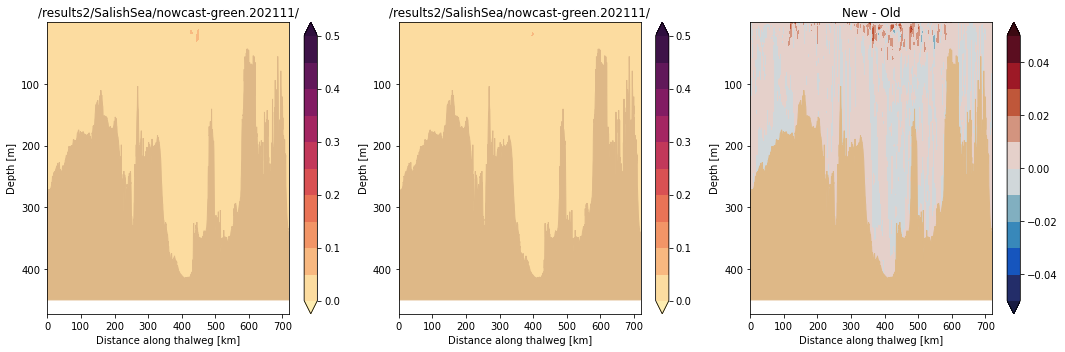

In [59]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Dissolved Silicon

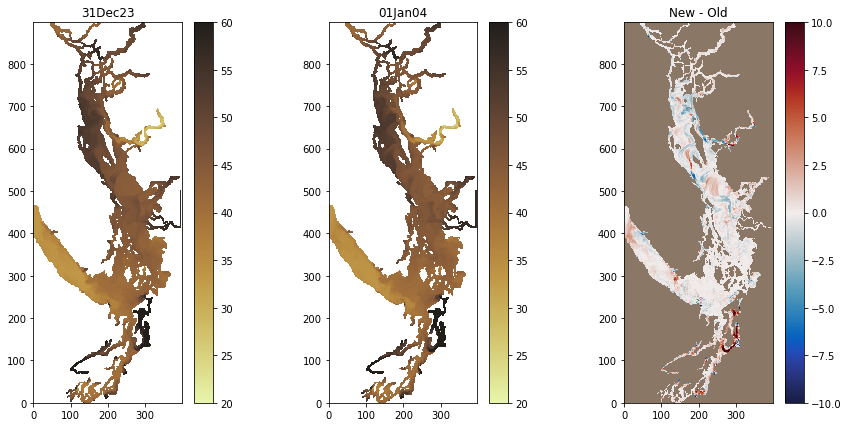

In [60]:
tracer = 'silicon'
file = 'biol'
month = '10'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 20
dvmax = 10
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax,it=23)

78.1236948173165 78.29051807095553


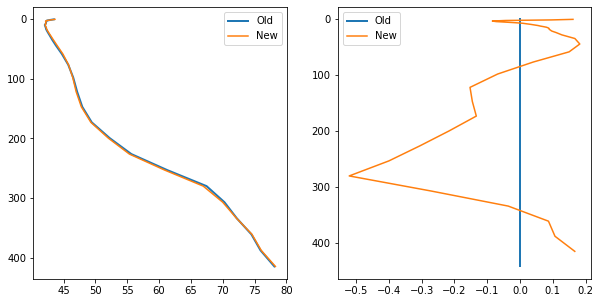

In [61]:
fig = profiles(tracer, file, it=23)

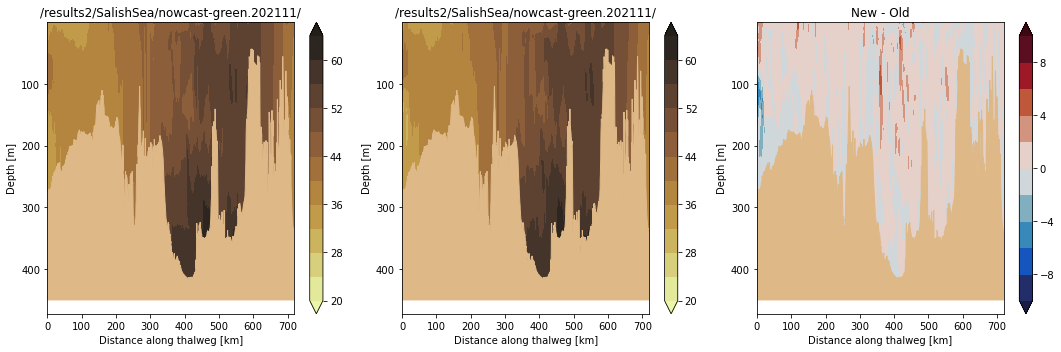

In [62]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## DIC

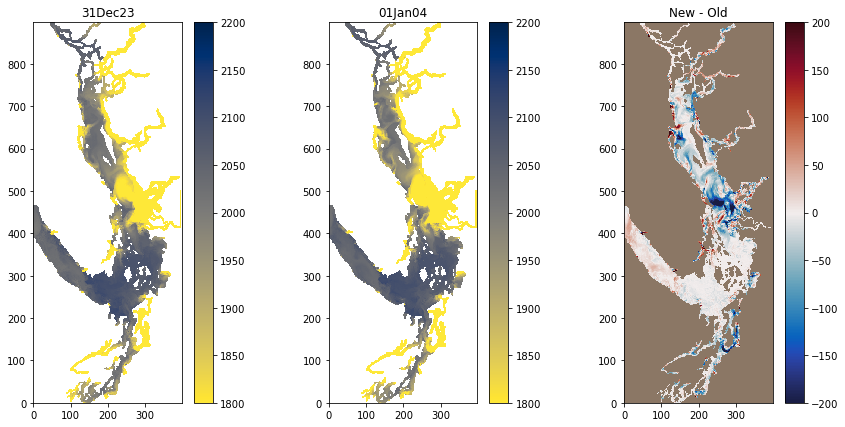

In [64]:
tracer = 'dissolved_inorganic_carbon'
file = 'chem'
month = '11'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1800
dvmax = 200
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

2141.3397291644874 2141.2266299531198


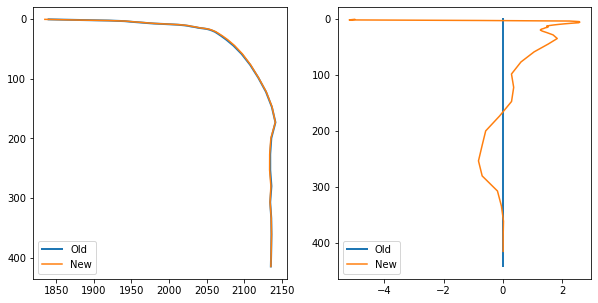

In [65]:
fig = profiles(tracer, file, it=23)

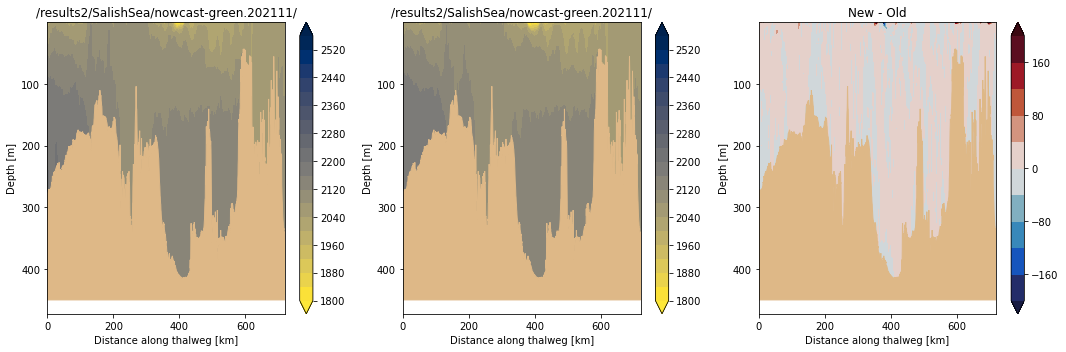

In [66]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Alkalinity

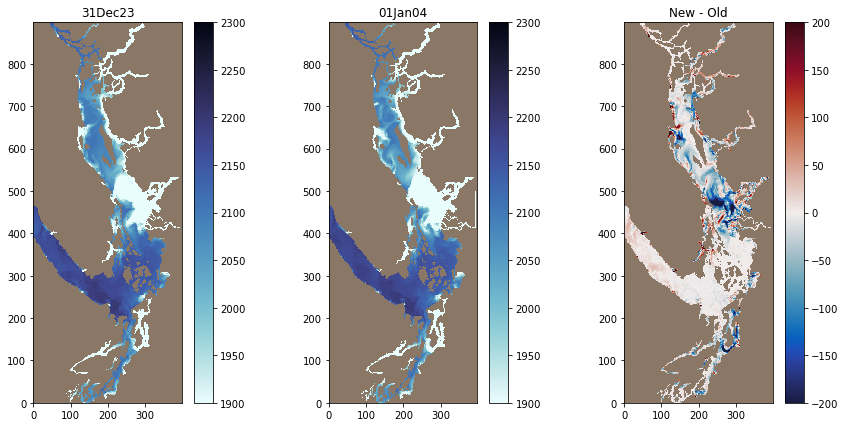

In [67]:
tracer = 'total_alkalinity'
file = 'chem'
month = '12'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1900
dvmax = 200
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

2195.273007502781 2196.2432808963686


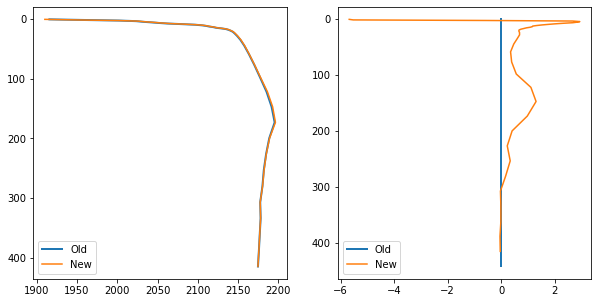

In [68]:
fig = profiles(tracer, file, it=23)

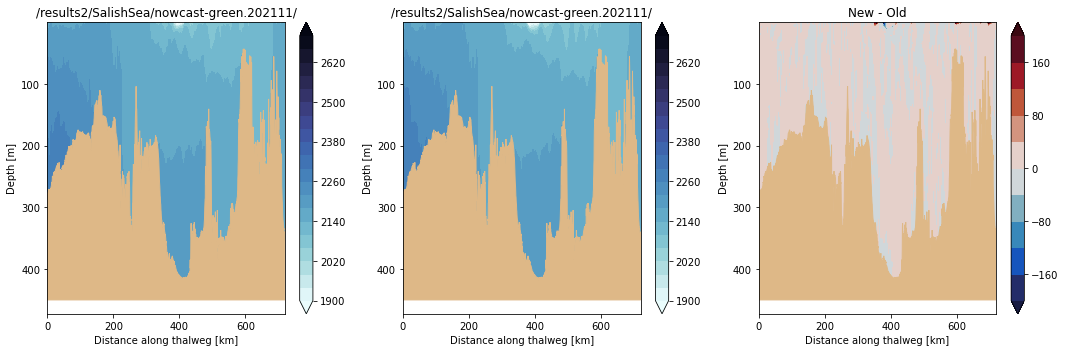

In [69]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)

## Fraser Tracer

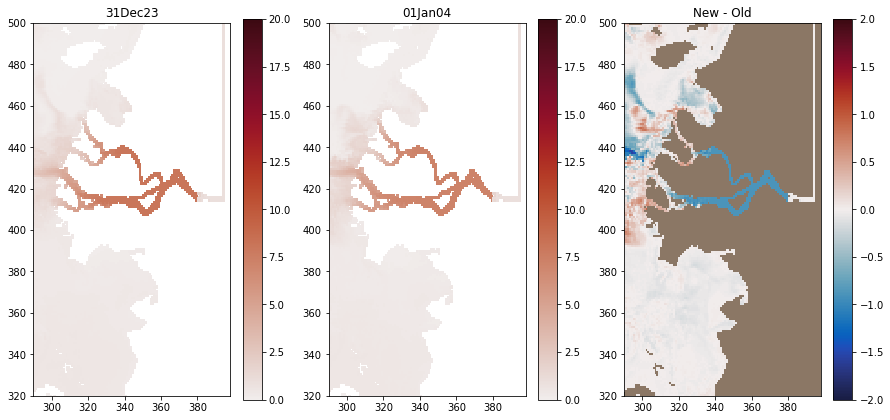

In [74]:
tracer = 'turbidity'
file = 'chem'
month = '12'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23, dl=0,
                    zoom=[320, 500, 290, 398])

# Oxygen

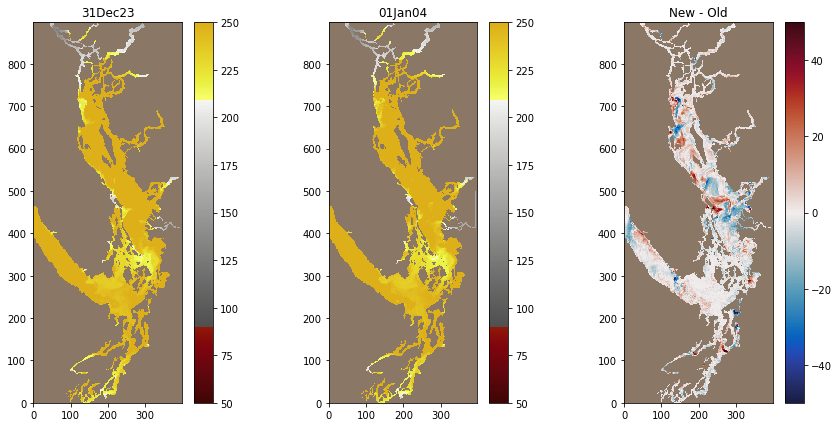

In [75]:
tracer = 'dissolved_oxygen'
file = 'chem'
month = '12'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 250
vmin = 50
dvmax = 50
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, it=23)

253.4439518277163 253.21789097374048


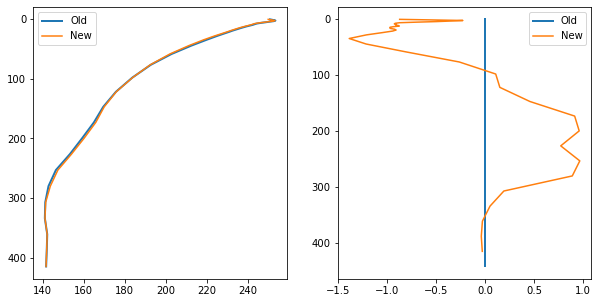

In [76]:
fig = profiles(tracer, file, it=23)

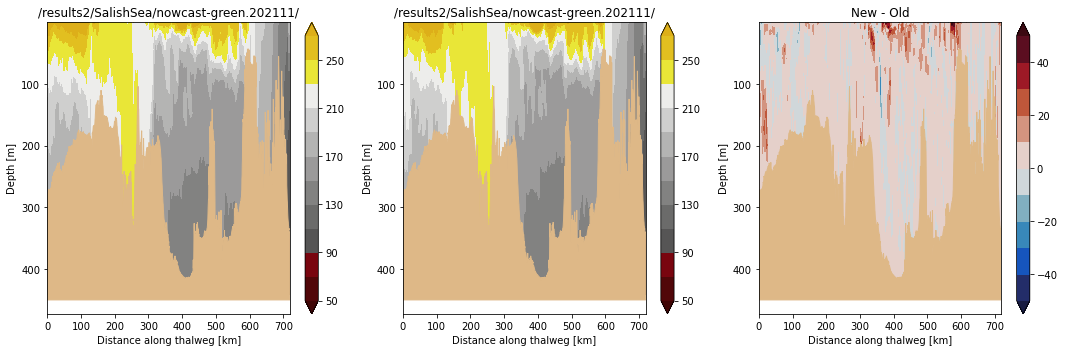

In [77]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax, it=23)